<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Чтение-и-подготовка-данных" data-toc-modified-id="Чтение-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Чтение и подготовка данных</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Анализ-воронки-событий" data-toc-modified-id="Анализ-воронки-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ воронки событий</a></span></li><li><span><a href="#Анализ-результатов-A/A/B-теста" data-toc-modified-id="Анализ-результатов-A/A/B-теста-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ результатов A/A/B-теста</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Анализ приложения для покупок продуктов питания

Цель исследования - разобраться, как ведут себя пользователи мобильного приложения, который продаёт продукты питания.

Необходимо изучить воронку продаж. Узнать, как пользователи доходят до покупки.

Также нужно исследовать результаты A/A/B-эксперимента по замене шрифта во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Задача - выяснить, какой шрифт лучше.

## Чтение и подготовка данных

In [1]:
#!pip install plotly
#!pip install -U kaleido

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns            
from scipy import stats as st
import numpy as np
import datetime as dt
import math as mth 
from plotly import graph_objects as go

import warnings
warnings.simplefilter('ignore')



In [2]:
df_logs = pd.read_csv('/content/logs_exp.csv', sep='\t')
display(df_logs.info())
display(df_logs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Заменим название столбцов на более удобные и проверим дубликаты в таблице.

In [3]:
#Переименование столбцов
df_logs = df_logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_timestamp', 'ExpId':'group'})
#Проверка на дубликаты
df_logs.duplicated().sum()

413

Вероятно дубликаты появились из-за технической ошибки и задвоения событий. Необходимо уточнить природу появления повторов, чтобы не допустить их дальнейшего появления. Однако в данном случае количество дубликатов очень мало (0,17%), поэтому мы можем их удалить.

In [4]:
#Удаление полных дубликатов
df_logs = df_logs.drop_duplicates()
df_logs.duplicated().sum()

0

Проверим не попал ли кто-то из пользователей в несколько групп сразу.

In [5]:
#Группируем по user_id и считаем кол-во уникальных групп, сортируем по убыванию
df_logs.groupby('user_id')['group'].nunique().reset_index().sort_values('group', ascending=False).head(10)

,user_id,group
0,6888746892508752,1
5030,6207768971558512760,1
5042,6217807653094995999,1
5041,6217295124800833842,1
5040,6216080220799726690,1
5039,6215559225876063378,1
5038,6215162890135937308,1
5037,6213626876710715478,1
5036,6213410662941116891,1
5035,6212635085994550838,1


Пользователей, попавших в несколько групп не обнаружено.

Приведем столбец `event_timestamp` к читаемому виду, а также добавим отдельный столбец с датой события.

In [6]:
df_logs['event_timestamp'] = df_logs['event_timestamp'].astype('datetime64[s]')
df_logs['event_date'] = df_logs['event_timestamp'].astype('datetime64[D]')
df_logs.head()

,event_name,user_id,event_timestamp,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Мы переименовали столбцы, избавились от дубликатов, перевели `timestamp` в читаемый вид и добавили новый столбец с датой события.**

**В результате имеем таблицу `df_logs`:**
- event_name — название события;
- user_id — уникальный идентификатор пользователя;
- event_timestamp — время события;
- group — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;
- event_date - дата события.

## Изучение и проверка данных

In [7]:
print(f'Всего в таблице {len(df_logs)} событий.') 
print(f'Уникальных пользователей: {len(df_logs.user_id.unique())}.')
print(f'В среднем на одного пользователя приходится: {round(len(df_logs) / len(df_logs.user_id.unique()))} события.')

Всего в таблице 243713 событий.
Уникальных пользователей: 7551.
В среднем на одного пользователя приходится: 32 события.


In [8]:
print(f'Уникальных наименований событий: {len(df_logs.event_name.unique())}, а именно:')
print(df_logs.event_name.unique().tolist())

Уникальных наименований событий: 5, а именно:
['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']


In [9]:
print(f'Мы располагаем данными за период от {df_logs.event_date.dt.date.min()} по {df_logs.event_date.dt.date.max()}')

Мы располагаем данными за период от 2019-07-25 по 2019-08-07


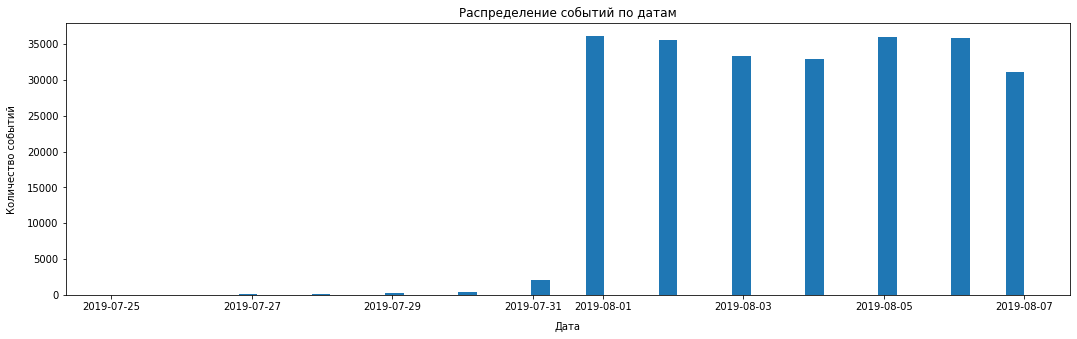

In [10]:
plt.figure(figsize= (18, 5))
plt.hist(df_logs['event_date'], bins = 50)
plt.title('Распределение событий по датам')
plt.xlabel('Дата', labelpad=10)
plt.ylabel('Количество событий', labelpad=10)
plt.show()

**По факту видим, что полные данные мы имеем только за период с 2019-08-01 по 2019-08-07. Далее будем рассматривать данные только за эти 7 дней, остальные события отбросим.**

In [11]:
#Создаем таблицы отфильтрованную по датам с 2019-08-01 по 2019-08-07
df_logs_good = df_logs.query('event_date >= "2019-08-01" and event_date <= "2019-08-07"')

#Считаем кол-во потерянных событий и пользователей после фильтрации
print('В результате фильтрации данных мы потеряли {} ({:.2%}) событий и {} ({:.2%}) пользователей.'.format(
len(df_logs) - len(df_logs_good), (len(df_logs) - len(df_logs_good))/len(df_logs),  len(df_logs.user_id.unique()) - len(df_logs_good.user_id.unique()), (len(df_logs.user_id.unique()) - len(df_logs_good.user_id.unique()))/len(df_logs.user_id.unique())))

В результате фильтрации данных мы потеряли 2826 (1.16%) событий и 17 (0.23%) пользователей.


Проверим количество пользователей попавших в каждую группу.

In [12]:
df_group_count = df_logs_good.groupby('group')['user_id'].nunique().reset_index()

#Добавим в таблицу результат по объединенным контрольным группам
control_groups = pd.DataFrame(
    [['246+247', df_logs_good[(df_logs_good['group']==246) | (df_logs_good['group']==247)]['user_id'].nunique()]],
    columns = ['group', 'user_id'])
df_group_count = pd.concat([df_group_count, control_groups]).reset_index(drop=True)

df_group_count


,group,user_id
0,246,2484
1,247,2513
2,248,2537
3,246+247,4997


Распределение пользователей в группах достаточно равномерное.

## Анализ воронки событий

Посчитаем как часто встречается каждое событие.

In [13]:
df_eventname_count = df_logs_good.groupby('event_name')['user_id'].count().reset_index().sort_values('user_id', ascending=False)
df_eventname_count.columns = ['event_name', 'count']
df_eventname_count

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Посчитаем сколько пользователей (а также долю пользователей) совершали каждое из этих событий.

In [14]:
#Группируем таблицу по названию событий и считаем количество уникальных пользователей
df_eventname_userunique = df_logs_good.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)
df_eventname_userunique.columns = ['event_name', 'user_counts']
#Создаем столбец с долей пользователей в каждом событие от общего кол-ва уникальных пользователей в df_logs_good
df_eventname_userunique['part'] = (df_eventname_userunique['user_counts'] / len(df_logs_good.user_id.unique())).round(2)
df_eventname_userunique

,event_name,user_counts,part
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


**Исходя из долей пользователей в каждом событие, можем предположить, что события происходят в следующем порядке:**
1. MainScreenAppear - главная страница
2. OffersScreenAppear - страница с предложением
3. CartScreenAppear - страница с корзиной
4. PaymentScreenSuccessful - страница успешной оплаты

**Данный порядок выглядит правильным и по логике осуществления действий в приложении. <br>Событие "Tutorial" (инструкция), расположенное по таблице в конце воронки, не кажется логичным продолжением процесса оплаты. Вероятно это событие никак не влияет на остальные, поэтому учитывать его в воронке событий не будем.**

**Также мы видим, что не все пользователи попали в приложение через главную страницу. Видимо 2% пользователей попали напрямую на страницу с предложением с различного рода рекламных ссылок.**

Посчитаем конверсию в каждое последующее событие, то есть какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [15]:
#Убираем из таблицы df_eventname_userunique событие 'Tutorial' для отображения воронки
df_eventname_convers = df_eventname_userunique.reset_index(drop=True).drop(index=[4])
df_eventname_convers

,event_name,user_counts,part
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


In [16]:
#Считаем конверсию в следующее событие.
#Перебираем строки в таблице. Начиная со второй, находим отношение user_counts к предыдущей строке

part_from_prev = []
for i in df_eventname_convers.index:
    if i == 0:
        part = 1
    else:
        part = (df_eventname_convers.loc[i][1]/df_eventname_convers.loc[i-1][1]).round(2)
    part_from_prev.append(part)   

df_eventname_convers['part_from_prev'] = part_from_prev
df_eventname_convers

,event_name,user_counts,part,part_from_prev
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


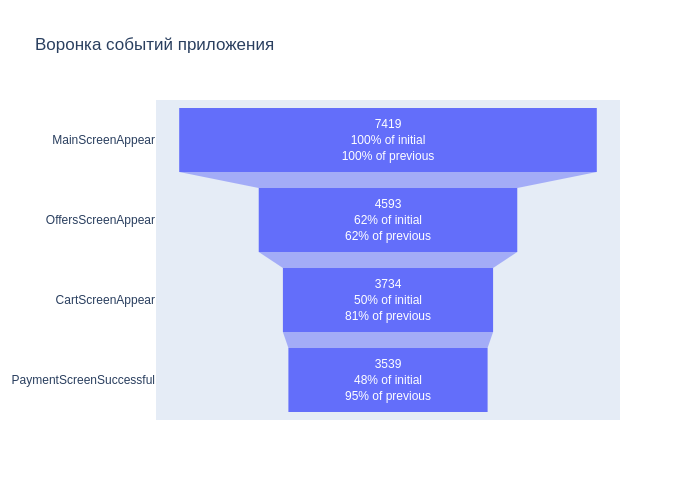

In [17]:
#Создаем список событий
events = df_eventname_convers['event_name']

fig = go.Figure(
    go.Funnel(
        y=events,
        x=df_eventname_convers['user_counts'],
        textposition = "inside",
        textinfo = "value+percent previous+percent initial",
        
    )
)
fig.update_layout(height=500, width=700, title='Воронка событий приложения')
fig.show("png") 


**По полученным значениям конверсии из события в событие можем определить, что больше всего пользователей теряется после первого события. Всего 62% переходят на страницу с предложением. Это может говорить о том, что интерфейс главной страницы не удобен для продолжения работы с приложением.**

In [18]:
print('Доля дошедших от первого события до оплаты: ', (
    df_eventname_convers.loc[3][1] / df_eventname_convers.loc[0][1]).round(2))

Доля дошедших от первого события до оплаты:  0.48


**От первого события до оплаты доходит чуть меньше половины пользователей (48%).**

Рассмотрим продуктовую воронку с учётом последовательности событий.

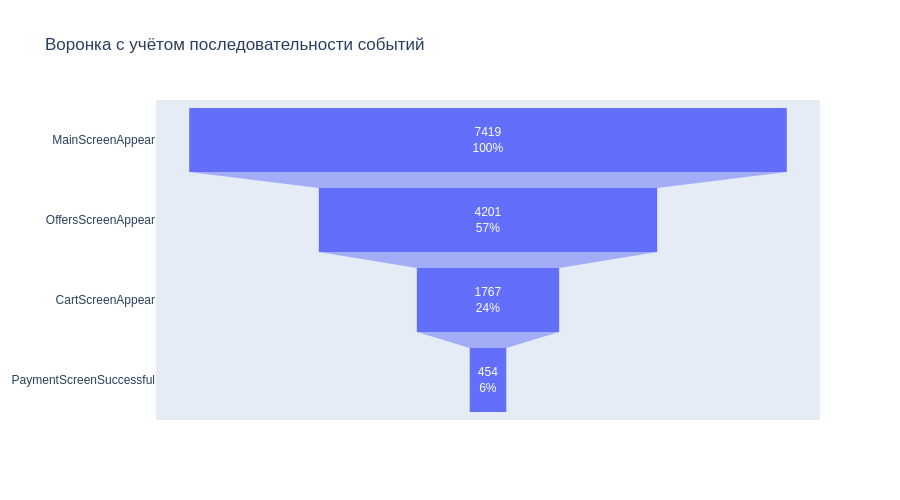

In [19]:
#Находим время первых совершенных действий пользователей по каждому событию
users = df_logs_good[df_logs_good['event_name'] != 'Tutorial'].pivot_table(
        index='user_id', 
        columns='event_name', 
        values='event_timestamp',
        aggfunc='min').reset_index()

#Находим кол-во (кол-во строк) пользователей, которые начали с первого события
#и далее время последующего события было больше предыдущего
funnel_seq = []
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])
funnel_seq.append(users[step_1].shape[0])
funnel_seq.append(users[step_2].shape[0])
funnel_seq.append(users[step_3].shape[0])
funnel_seq.append(users[step_4].shape[0])


fig = go.Figure(
    go.Funnel(
        y=events,
        x=funnel_seq,
        textposition = "inside",
        textinfo = "value+percent initial",
   )
)
fig.update_layout(height=500, width=900, title='Воронка с учётом последовательности событий')
fig.show("png") 

**Сравнивая две воронки наблюдаем, что далеко не все пользователи идут по ожидаемому пути из событий.**

##  Анализ результатов A/A/B-теста

In [20]:
#Считаем долю пользователей в каждой группе от общего количества
df_group_count['part'] = (df_group_count['user_id'] / len(df_logs_good.user_id.unique())).round(2)
df_group_count.index = df_group_count['group']
df_group_count = df_group_count.drop(columns='group')

df_group_count

,user_id,part
group,,
246,2484,0.33
247,2513,0.33
248,2537,0.34
246+247,4997,0.66


**Как отмечали ранее распределение пользователей в группах достаточно равномерное (33-34%).**

Посчитаем количество пользователей на каждом событие в каждой группе отдельно.

In [21]:
#Создаем список групп
groups = df_group_count.index

#Создаем таблицу с воронкой: считаем кол-во уникальных пользователей на каждом событии в каждой группе
funnel = {}
for group in groups:
    funnel[group] = []
    for event in events:
        funnel[group].append(df_logs_good[(df_logs_good['group'] == group) & (df_logs_good['event_name'] == event)]['user_id'].nunique())


df_funnel = pd.DataFrame(funnel)
df_funnel['246+247'] = df_funnel[246] + df_funnel[247]
df_funnel['event_name'] = events
df_funnel

,246,247,248,246+247,event_name
0,2450,2476,2493,4926,MainScreenAppear
1,1542,1520,1531,3062,OffersScreenAppear
2,1266,1238,1230,2504,CartScreenAppear
3,1200,1158,1181,2358,PaymentScreenSuccessful


**Наиболее популярное событие во всех группах - "MainScreenAppear" (главная страница).**

Создадим воронку событий с конверсиями для каждой пары групп и проверим статистическую значимость результатов конверсии.

In [22]:
#Функция для расчета p-value (для каждого события) и построения воронки для двух групп
def p_value_test(group_1, group_2, alpha):
    alpha = alpha
    for i in df_funnel.index:
        #Доля пользователей, перешедших на событие в первой группе
        p1 = df_funnel[group_1][i] / df_group_count['user_id'][group_1]
        #Доля пользователей, перешедших на событие во второй группе
        p2 = df_funnel[group_2][i] / df_group_count['user_id'][group_2]
        #Доля пользователей, перешедших на событие в сумме двух групп
        p12 = (df_funnel[group_1][i] + df_funnel[group_2][i]) / (df_group_count['user_id'][group_1] + df_group_count['user_id'][group_2])
        #Разница долей в группах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p12 * (1 - p12) * 
                                        (1/df_group_count['user_id'][group_1] + 1/df_group_count['user_id'][group_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('{} p-значение: {}'.format(df_funnel['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
    fig = go.Figure()
    for i, group in enumerate([group_1, group_2]):
        fig.add_trace(go.Funnel(
            name = str(group),
            y = events,
            x = df_funnel[group],
            textposition = "inside",
            textinfo = "value+percent previous+percent initial",))
    fig.update_layout(height=500, width=800, title='Воронка событий приложения')
    fig.show("png")

Мы будем проводить 16 тестов на одних и тех же данных, поэтому будем использовать поправку Бонферрони для коррекции уровня значимости.

Группы 246 и 247 (А/А-тест):

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



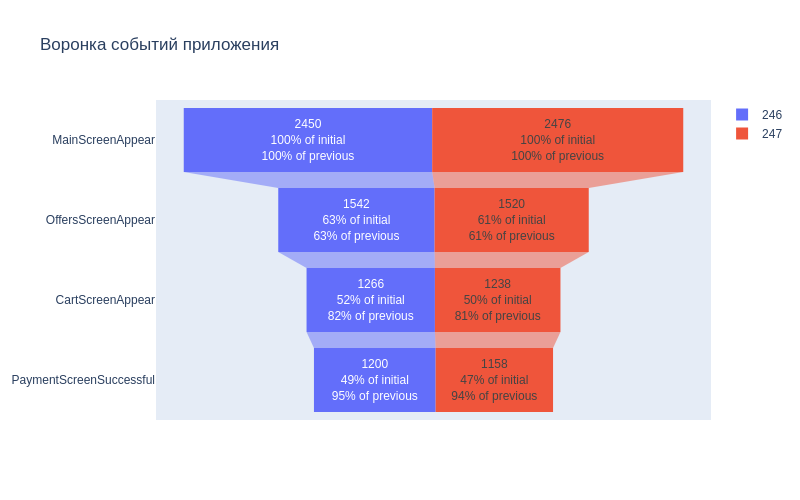

In [23]:
p_value_test(246, 247, 0.05/16)

**Как видим из результатов, ни для оного из событий разница не оказалось значимой. Обе эти группы можно считать контрольными и доверять распределению пользователей в тестовой группе.**

Аналогично сравним тестовую группу (248) с каждой из контрольных групп (246 и 247).

Группы 246 и 248:

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



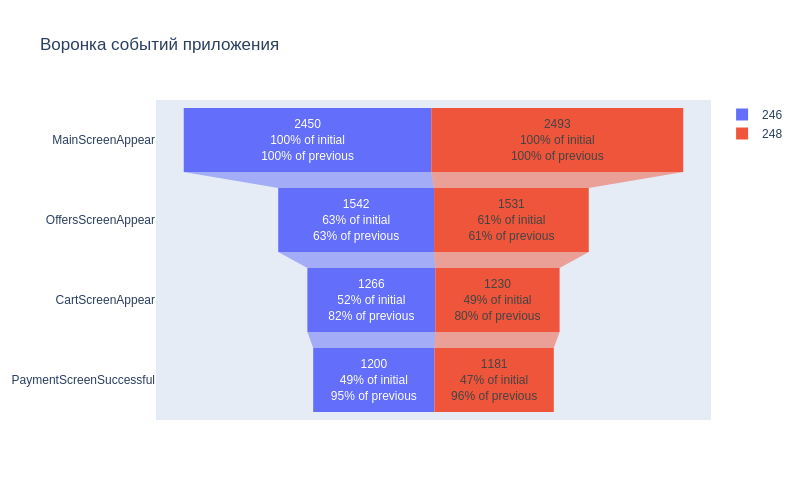

In [24]:
p_value_test(246, 248, 0.05/16)

Группы 247 и 248:

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



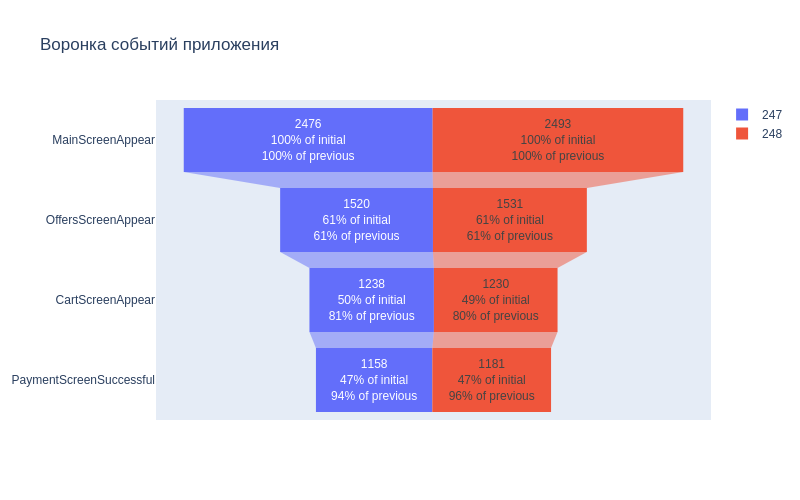

In [25]:
p_value_test(247, 248, 0.05/16)

**При сравнение контрольных групп с тестовой ни одно из событий также не показало значимых различий.**

Теперь сравним контрольные 246 и 247, объединенные в одну группу, с тестовой 248-ой:

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



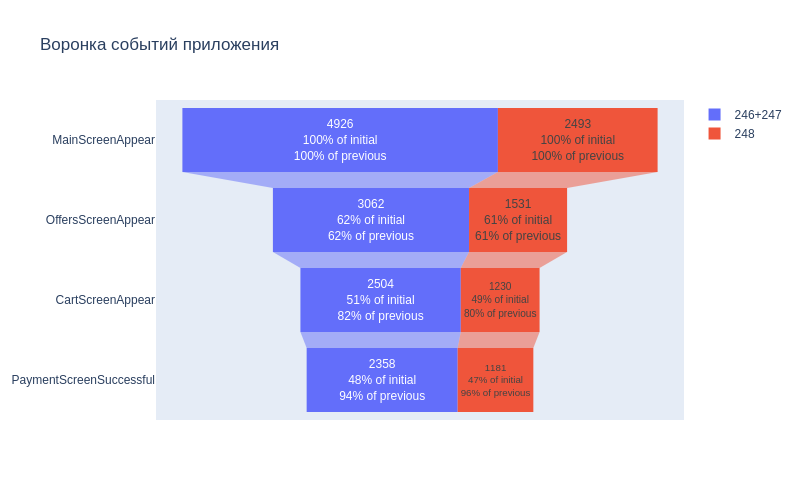

In [26]:
p_value_test('246+247', 248, 0.05/16)

**Сравнение тестовой группы с объединенными контрольными также не показали статистически значимых различий в конверсиях.**

## Выводы

Проанализировав логи мобильного предложения, можем сделать следующие выводы:

- наиболее популярное событие - MainScreenAppear (главная страница);


- она же соответственно является первым событием в воронке:
    1. MainScreenAppear - главная страница
    2. OffersScreenAppear - страница с предложением
    3. CartScreenAppear - страница с корзиной
    4. PaymentScreenSuccessful - страница успешной оплаты  


- до оплаты (конца воронки) доходит 48% пользователей;


- самая низкая конверсия на этапе `MainScreenAppear → OffersScreenAppear`, это может говорить о недоработках в интерфейсе главной страницы;


- мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (использовали поправку Бонферонни для множественных тестов), 12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом, и ни одна из них не выявила значимой разницы, что говорит об отсутствии разницы в конверсии для сравниваемых шрифтов.

